# Main Lidar Processing Pipeline
This notebook takes a directory of tiles and runs it through a series of command line tools from `FUSION` and `LAStools` to generate useful vector and raster products. It is assumed that the tiles have buffers added to each tile to avoid edge effects (e.g., using notebook `02_Retile...` in this repo).

This pipeline performs denoising and deduplication, classifies points into buildings and vegetation, and generates raster products including 1m DEM, 1m hillshade, 0.5m intensity, and 0.5m canopy height model. 

In [1]:
import os
import shutil
import glob
import subprocess
import time
import pandas as pd
import geopandas as gpd
import dask
from dask.distributed import Client, progress, LocalCluster
from pyFIRS.wrappers import lastools, fusion
from pyFIRS.utils import (clean_buffer_polys, clip_tile_from_shp, 
                          convert_project, PipelineError, fname, 
                          processing_summary, inspect_failures)

In [2]:
# where the imported lidar data is currently stored
WORKDIR = os.path.abspath('/storage/lidar/portland-metro_2014/')

# the coordinate reference system we'll be working with
TARGET_EPSG = 6339  # utm 10N, nad83_2011
# TARGET_EPSG = 6340  # utm 11N, nad83_2011

### Setting up parallel computing using `dask.distributed`
`LAStools` offers native multi-core processing as an optional argument (`cores`) supplied to its command-line tools. `FUSION` command line tools do not. To enable parallel processing of `FUSION` commands, we'll use `dask.distributed` to schedule the processing of tiles in asynchronous parallel batches. This approach also offers us the ability to track progress using a progress bar.

You'll first need to launch a parallel computing cluster. 

In [3]:
cluster = LocalCluster(scheduler_port=7001, dashboard_address=7002)
c = Client(cluster)
num_cores = len(c.ncores())  # identify how many workers we have

At this point, you should also be able to view an interactive dashboard on port 7002. If you're executing this on a remote server, you'll need to set up port forward so you can view the dashboard on your local machine's browser. Once you've done that, or if you're processing on your own machine, you can view the dashboard at [http://localhost:7002/status](http://localhost:7002/status).

# Let's get to work with some lidar data

We'll define where we can find the binary executables for LAStools and FUSION command line tools.

In [4]:
las = lastools.useLAStools('/storage/lidar/LAStools/bin')
fus = fusion.useFUSION('/storage/lidar/FUSION/')

In [5]:
# define data handling directories
INTERIM = os.path.join(WORKDIR, 'interim')
PROCESSED = os.path.join(WORKDIR, 'processed')
LAYERS = os.path.join(INTERIM, 'layers')

In [6]:
def log_error(tile_id, process, error_msg):
    logfile = os.path.join(INTERIM, 'failed', tile_id + '.txt')
    os.makedirs(os.path.dirname(logfile), exist_ok=True)

    with open(logfile, '+w') as f:
        f.write('{} | {}: {}'.format(tile_id, process, error_msg))

    return


def has_error(tile_id):
    errors = glob.glob(os.path.join(INTERIM, 'failed', '*.txt'))
    tiles_with_errors = [fname(error) for error in errors]
    if tile_id in tiles_with_errors:
        return True
    else:
        return False

In [7]:
def parse_coords_from_tileid(tile_id):
    """Get the coordinates of the lower left corner of the tile, assuming the tile 
    has been named in the pattern {XMIN}_{YMIN}_{RASTERLENGTH}.
    
    Parameters
    ----------
    tile_id : string
        assumed tile_id follows the naming convention of {LLX}_{LLY}_{LENGTH} where 
        LLX = x-coordinate of lower-left corner of tile (in projected units)
        LLY = y-coordinate of lower-left corner of tile (in projected units)
        LENGTH = length of the raster (in projected units), assumed to be a square tile shape
    
    Returns
    -------
    llx, lly, length : int
        x- and y- coordinates of lower-left corner and length of raster
    """
    tile_parts = tile_id.split('_')
    if len(tile_parts) == 2:
        llx, lly = [int(coord) for coord in tile_parts]
        length = 1000 # assumed tile width if not explicit in tile_id
    elif len(tile_parts) == 3:
        llx, lly, length = [int(coord) for coord in tile_parts]
    
    return llx, lly, length

In [8]:
# push our working directories and wrapper classes to the workers on the cluster as well
c.scatter([INTERIM, PROCESSED, LAYERS, las, fus, TARGET_EPSG, 
           num_cores, has_error, log_error], 
          broadcast=True);

## 1. Classify points in the lidar point cloud

If the original tiles delivered by the vendor included overlapping edges, our retiling may result in duplicated points in the new tiles from overlapping edges of vendor-provided input tiles. In the next step, we will ensure that only one point with unique (X,Y,Z) coordinates are retained in the point cloud data.

In [9]:
@dask.delayed
def remove_duplicate_points(tile_id):
    infile = os.path.join(INTERIM, 'retiled', tile_id + '.laz')

    if not os.path.exists(os.path.join(PROCESSED, 'points', tile_id + '.laz')):
        try:
            proc = las.lasduplicate(i=infile,
                                    unique_xyz=True,
                                    olay=True,
                                    olaydir=LAYERS,
                                    odir=LAYERS)
        except PipelineError as e:
            log_error(tile_id, 'remove_duplicate_points', e.message)
    else:  # output file already exists
        pass

    return tile_id

In [10]:
@dask.delayed
def height_above_ground(tile_id):
    infile = os.path.join(INTERIM, 'retiled', tile_id + '.laz')

    if not has_error(tile_id) and \
    not os.path.exists(os.path.join(PROCESSED, 'points', tile_id + '.laz')):
        try:
            proc = las.lasheight(i=infile,
                                 ilaydir=LAYERS,
                                 olay=True,
                                 classify_below=(-1.0, 7),  # noise
                                 olaydir=LAYERS)
        except PipelineError as e:
            log_error(tile_id, 'height_above_ground', e)

    else:  # this tile already has an error recorded in the error_log
        pass

    return tile_id

Now we'll remove points that are isolated as likely noise.

In [11]:
@dask.delayed
def denoise(tile_id):
    infile = os.path.join(INTERIM, 'retiled', tile_id + '.laz')

    if not has_error(tile_id) and \
    not os.path.exists(os.path.join(PROCESSED, 'points', tile_id + '.laz')):
        try:
            proc = las.lasnoise(i=infile,
                                ilaydir=LAYERS,
                                olay=True,
                                step=2,  # cell-size for 3x3x3 search area
                                isolated=10,  # min. neighbors in search area
                                olaydir=LAYERS)
        except PipelineError as e:
            log_error(tile_id, 'denoise', e)

    else:  # this tile already has an error recorded in the error_log
        pass

    return tile_id

Now, we'll classify points as building or high vegetation that meet certain criteria for 'planarity' or 'ruggedness'. 

**THERE ARE ARGUMENTS IN THE FOLLOWING COMMAND THAT DEPEND UPON THE UNITS OF THE DATA.**

In [12]:
@dask.delayed
def classify(tile_id):
    infile = os.path.join(INTERIM, 'retiled', tile_id + '.laz')
    ODIR = os.path.join(PROCESSED, 'points')

    if not has_error(tile_id) and \
    not os.path.exists(os.path.join(PROCESSED, 'points', tile_id + '.laz')):
        try:
            proc = las.lasclassify(i=infile,
                                   ilaydir=LAYERS,
                                   step=2.0,
                                   planar=0.1,  # if your data are in meters
                                   rugged=0.4,  # if your data are in meters
                                   olaz=True,
                                   odir=ODIR)
        except PipelineError as e:
            log_error(tile_id, 'classify', e.message)

    else:  # this tile already has an error recorded in the error_log
        pass

    return tile_id

In [13]:
@dask.delayed
def fusion_intensity(tile_id):
    infile = os.path.join(PROCESSED, 'points', tile_id + '.laz')
    ODIR = os.path.join(INTERIM, 'intensity_tiles')
    outfile = os.path.join(ODIR, tile_id + '.bmp')
        
    if not has_error(tile_id):
        try:
            proc_fus = fus.intensityimage(0.5,
                                          outfile,
                                          infile,
                                          odir=ODIR,
                                          rasterorigin=True,
#                                           intrange=(1,254)
                                         )
        except PipelineError as e:
            log_error(tile_id, 'fusion_intensity', e.message)
    
    else:  # this tile already has an error recorded in the error_log
        pass

    return tile_id

In [14]:
@dask.delayed
def reformat_intensity(tile_id):
    infile = os.path.join(INTERIM, 'intensity_tiles', tile_id + '.bmp')
    ODIR = os.path.join(PROCESSED, 'rasters', 'intensity_tiles')
    outfile = os.path.join(ODIR, tile_id + '.tif')
    os.makedirs(ODIR, exist_ok=True)

    tile_llx, tile_lly, tile_len = parse_coords_from_tileid(tile_id)
    ul_x, ul_y = tile_llx, tile_lly + tile_len
    lr_x, lr_y = tile_llx + tile_len, tile_lly
        
    if not has_error(tile_id):
        try:
            proc_gdal = subprocess.run(['gdal_translate',
                                        '-of', 'GTiff',
                                        '-b', '1',
                                        '-a_nodata', '255',
                                        '-projwin', str(ul_x), str(ul_y), str(lr_x), str(lr_y),
                                        '-projwin_srs', 'EPSG:{}'.format(TARGET_EPSG),
                                        '-a_srs', 'EPSG:{}'.format(TARGET_EPSG),
                                        '-colorinterp', 'gray',
                                        infile,
                                        outfile], 
                                       stderr=subprocess.PIPE,
                                       stdout=subprocess.PIPE)
        except PipelineError as e:
                log_error(tile_id, 'reformat_intensity', e.message)
    
    else:  # this tile already has an error recorded in the error_log
        pass

    return tile_id

##### 2. Generate a bare earth Digital Elevation Model
Generate tiles of the bare earth model. This assumes that there are already ground-classified points

In [15]:
@dask.delayed
def make_dem(tile_id):
    infile = os.path.join(PROCESSED, 'points', tile_id + '.laz')
    ODIR = os.path.join(INTERIM, 'dem_tiles')
    outfile = os.path.join(ODIR, tile_id + '.tif')

    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = las.las2dem(i=infile,
                                   odir=ODIR,
                                   otif=True,  # output GeoTIFF
                                   keep_class=2,  # ground returns only
                                   step=1,
                                   thin_with_grid=1,  # resolution for TIN
                                   extra_pass=True)
            except PipelineError as e:
                log_error(tile_id, 'make_dem', e.message)
    else:  # output file already exists
        pass

    return tile_id

In [16]:
@dask.delayed
def reformat_dem(tile_id):
    infile = os.path.join(INTERIM, 'dem_tiles', tile_id + '.tif')
    ODIR = os.path.join(PROCESSED, 'rasters', 'dem_tiles')
    outfile = os.path.join(ODIR, tile_id + '.tif')
    os.makedirs(ODIR, exist_ok=True)

    tile_llx, tile_lly, tile_len = parse_coords_from_tileid(tile_id)
    ul_x, ul_y = tile_llx, tile_lly + tile_len
    lr_x, lr_y = tile_llx + tile_len, tile_lly
        
    if not has_error(tile_id):
        try:
            proc_gdal = subprocess.run(['gdal_translate',
                                        '-of', 'GTiff',
                                        '-projwin', str(ul_x), str(ul_y), str(lr_x), str(lr_y),
                                        '-projwin_srs', 'EPSG:{}'.format(TARGET_EPSG),
                                        '-a_srs', 'EPSG:{}'.format(TARGET_EPSG),
                                        infile,
                                        outfile], 
                                       stderr=subprocess.PIPE,
                                       stdout=subprocess.PIPE)
        except PipelineError as e:
                log_error(tile_id, 'reformat_dem', e.message)
    
    else:  # this tile already has an error recorded in the error_log
        pass

    return tile_id

To create a hillshade layer, we'll first, generate hillshade tiles from the bare earth model.

In [17]:
@dask.delayed
def make_hillshade(tile_id):
    ## TO DO -- convert to GDALDEM HILLSHADE using DEM GeoTiff
    infile = os.path.join(PROCESSED, 'points', tile_id + '.laz')
    ODIR = os.path.join(INTERIM, 'hillshade_tiles')
    outfile = os.path.join(ODIR, tile_id + '.tif')

    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = las.las2dem(i=infile,
                                   odir=ODIR,
                                   otif=True,
                                   hillshade=True,
                                   keep_class=2,  # ground returns only
                                   step=1,
                                   thin_with_grid=1,  # resolution for TIN
                                   extra_pass=True)

            except PipelineError as e:
                log_error(tile_id, 'make_hillshade', e.message)
    else:  # output file already exists
        pass

    return tile_id

In [18]:
@dask.delayed
def make_dsm(tile_id):
    infile = os.path.join(PROCESSED, 'points', tile_id + '.laz')
    ODIR = os.path.join(INTERIM, 'dsm_tiles')
    outfile = os.path.join(ODIR, tile_id + '.tif')

    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = las.las2dem(i=infile,
                                   odir=ODIR,
                                   otif=True,
                                   hillshade=True,
                                   step=1,
                                   thin_with_grid=1,  # resolution for TIN
                                   extra_pass=True)

            except PipelineError as e:
                log_error(tile_id, 'make_dsm', e.message)
    else:  # output file already exists
        pass

    return tile_id

In [19]:
@dask.delayed
def reformat_hillshade(tile_id):
    infile = os.path.join(INTERIM, 'hillshade_tiles', tile_id + '.tif')
    ODIR = os.path.join(PROCESSED, 'rasters', 'hillshade_tiles')
    outfile = os.path.join(ODIR, tile_id + '.tif')
    os.makedirs(ODIR, exist_ok=True)

    tile_llx, tile_lly, tile_len = parse_coords_from_tileid(tile_id)
    ul_x, ul_y = tile_llx, tile_lly + tile_len
    lr_x, lr_y = tile_llx + tile_len, tile_lly
        
    if not has_error(tile_id):
        try:
            proc_gdal = subprocess.run(['gdal_translate',
                                        '-of', 'GTiff',
                                        '-projwin', str(ul_x), str(ul_y), str(lr_x), str(lr_y),
                                        '-projwin_srs', 'EPSG:{}'.format(TARGET_EPSG),
                                        '-a_srs', 'EPSG:{}'.format(TARGET_EPSG),
                                        infile,
                                        outfile], 
                                       stderr=subprocess.PIPE,
                                       stdout=subprocess.PIPE)
        except PipelineError as e:
                log_error(tile_id, 'reformat_hillshade', e.message)
    
    else:  # this tile already has an error recorded in the error_log
        pass

    return tile_id

## 3. Identify building footprints
First start by building shapefiles showing building boundaries in each buffered tile.

In [20]:
@dask.delayed
def make_building_footprint_tiles(tile_id):
    infile = os.path.join(PROCESSED, 'points', tile_id + '.laz')
    ODIR = os.path.join(INTERIM, 'building_tiles')
    outfile = os.path.join(ODIR, tile_id + '.shp')

    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = las.lasboundary(i=infile,
                                       keep_class=6,  # building points
                                       disjoint=True,  # separate polygons
                                       concavity=1,  # min edge length
                                       oshp=True,
                                       odir=ODIR)
            except PipelineError as e:
                log_error(tile_id, 'make_building_footprint_tiles', e.message)
    else:  # output file already exists
        pass

    return tile_id

Generate shapefiles showing the bounding box of each (unbuffered) tile that we'll use to remove buildings that fall in the buffered area.

In [21]:
@dask.delayed
def unbuffered_tile_boundary(tile_id):
    infile = os.path.join(PROCESSED, 'points', tile_id + '.laz')
    ODIR = os.path.join(INTERIM, 'tile_boundaries')
    outfile = os.path.join(ODIR, tile_id + '.shp')

    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = las.lasboundary(i=infile,
                                       odir=ODIR,
                                       oshp=True,
                                       use_tile_bb=True)
            except PipelineError as e:
                log_error(tile_id, 'unbuffered_tile_boundary', e.message)
    else:  # output file already exists
        pass

    return tile_id

For each shapefile containing polygons of the building boundaries, we'll use the `clean_buffer_polys` function from `pyFIRS.utils` to remove polygons from a tile if their centroid falls in the buffered area of the tile.

In [22]:
@dask.delayed
def remove_building_buffers(tile_id, *args):
    if type(tile_id) == list:
        tile_id = tile_id[0]

    infile = os.path.join(INTERIM, 'building_tiles', tile_id + '.shp')
    tile_shp = os.path.join(INTERIM, 'tile_boundaries', tile_id + '.shp')
    ODIR = os.path.join(PROCESSED, 'vectors', 'building_tiles')
    outfile = os.path.join(ODIR, tile_id + '.shp')

    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                clean_buffer_polys(infile,
                                   tile_shp,
                                   odir=ODIR,
                                   simp_tol=3,
                                   simp_topol=True)
            except Exception as e:
                log_error(tile_id, 'remove_building_buffers', e.message)
    else:  # output file already exists
        pass

    return tile_id

## 4. Create a Canopy Height Model
We're going to switch use a FUSION command line tool to generate a Canopy Height Models (CHMs). 

### Using FUSION's `canopymodel` to generate CHMs
`FUSION` wants to have ground models formatted as .dtm files, for CHM development and for estimating other canopy metrics. Let's generate these ground models first using a 1-meter x-y resolution.

In [23]:
@dask.delayed
def make_ground_dtm(tile_id):
    infile = os.path.join(PROCESSED, 'points', tile_id + '.laz')
    ODIR = os.path.join(INTERIM, 'dtm_ground_tiles')
    outfile = os.path.join(ODIR, tile_id + '.dtm')

    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = fus.gridsurfacecreate(surfacefile=outfile,
                                             cellsize=1,
                                             xyunits='M',
                                             zunits='M',
                                             coordsys=1,  # UTM
                                             zone='10N',
                                             horizdatum=2,  # NAD83
                                             vertdatum=2,  # NAVD88
                                             datafile=infile,
                                             las_class=2,  # ground points
                                             odir=ODIR)
            except PipelineError as e:
                log_error(tile_id, 'make_ground_dtm', e.message)
    else:  # output file already exists
        pass

    return tile_id

In [24]:
@dask.delayed
def make_canopy_model(tile_id):
    infile = os.path.join(PROCESSED, 'points', tile_id + '.laz')
    ODIR = os.path.join(INTERIM, 'chm_tiles')
    outfile = os.path.join(ODIR, tile_id + '.dtm')
    groundfile = os.path.join(INTERIM, 'dtm_ground_tiles', tile_id + '.dtm')

    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = fus.canopymodel(surfacefile=outfile,
                                       cellsize=0.5,
                                       xyunits='M',
                                       zunits='M',
                                       coordsys=1,  # UTM
                                       zone='10N',  # UTM
                                       horizdatum=2,   # NAD83
                                       vertdatum=2,  # NAVD88
                                       datafiles=infile,
                                       ground=groundfile,
                                       median=3,  # kernel size
                                       las_class=(1, 2, 5),  # grd, unclas, veg
                                       outlier=(-1, 110),
                                       asc=True,  # also output in ascii format
                                       odir=ODIR)

            except PipelineError as e:
                log_error(tile_id, 'make_canopy_model', e.message)
    else:  # output file already exists
        pass

    return tile_id

Convert the ascii files that `canopymodel` generated into GeoTiffs and trim them to the unbuffered tile boundary.

In [25]:
@dask.delayed
def reformat_chm(tile_id):
    infile = os.path.join(INTERIM, 'chm_tiles', tile_id + '.asc')
    ODIR = os.path.join(PROCESSED, 'rasters', 'chm_tiles')
    outfile = os.path.join(ODIR, tile_id + '.tif')
    os.makedirs(ODIR, exist_ok=True)

    tile_llx, tile_lly, tile_len = parse_coords_from_tileid(tile_id)
    ul_x, ul_y = tile_llx, tile_lly + tile_len
    lr_x, lr_y = tile_llx + tile_len, tile_lly
        
    if not has_error(tile_id):
        try:
            proc_gdal = subprocess.run(['gdal_translate',
                                        '-of', 'GTiff',
                                        '-projwin', str(ul_x), str(ul_y), str(lr_x), str(lr_y),
                                        '-projwin_srs', 'EPSG:{}'.format(TARGET_EPSG),
                                        '-a_srs', 'EPSG:{}'.format(TARGET_EPSG),
                                        infile,
                                        outfile], 
                                       stderr=subprocess.PIPE,
                                       stdout=subprocess.PIPE)
        except PipelineError as e:
                log_error(tile_id, 'reformat_chm', e.message)
    
    else:  # this tile already has an error recorded in the error_log
        pass

    return tile_id

In [26]:
@dask.delayed
def treeseg(tile_id):
    infile = os.path.join(INTERIM, 'chm_tiles', tile_id + '.dtm')
    ODIR = os.path.join(INTERIM, 'chm_tiles', 'treesegs')
    outfile = os.path.join(ODIR, tile_id)
    tile_llx, tile_lly, tile_len = parse_coords_from_tileid(tile_id)

    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = fus.treeseg(chm=infile,
                                   ht_threshold=137,
                                   outputfile=outfile,
                                   shape=True,
                                   cleantile=True,
                                   htmultiplier=0.01,
                                   grid=(tile_llx, tile_lly, tile_len, tile_len),
                                   buffer=50,
                                   projection=os.path.join(INTERIM, 'tile_boundaries', tile_id+'.prj'),
                                   odir=ODIR)

            except PipelineError as e:
                log_error(tile_id, 'make_treeseg', e.message)
    else:  # output file already exists
        pass

    return tile_id

In [27]:
# seg_res = c.persist([treeseg(tile) for tile in list(tile_ids)])
# progress(seg_res)

In [28]:
@dask.delayed
def tile_done(tile_id, *args, **kwargs):
    if type(tile_id) == list:
        tile_id = tile_id[0].split('unbuffered-')[-1]

    if not has_error(tile_id):
        outfile = os.path.join(INTERIM, 'finished', tile_id + '.txt')
        os.makedirs(os.path.dirname(outfile), exist_ok=True)

        with open(outfile, '+a') as f:
            f.write('{}'.format(tile_id))

    return tile_id


@dask.delayed
def tiles_done(*args, **kwargs):
    return

## Hand-build the computational graph
Define the recipe for computations.

In [29]:
tile_ids = set(fname(tile) for tile in
               glob.glob(os.path.join(INTERIM, 'retiled', '*.laz')))

failed_tiles = set(fname(tile) for tile in
                   glob.glob(os.path.join(INTERIM, 'failed', '*.txt')))

finished_tiles = set(fname(tile) for tile in
                     glob.glob(os.path.join(INTERIM, 'finished', '*.txt')))

tiles_to_process = list(tile_ids - failed_tiles - finished_tiles)

print('Found {:,d} tiles to process'.format(len(tiles_to_process)))

Found 4,270 tiles to process


In [30]:
dsk = {}
for tile in tiles_to_process:
    # pre-processing of lidar point clouds
    dsk['deduped-{}'.format(tile)] = (
        remove_duplicate_points,
        tile)
    dsk['normalized-{}'.format(tile)] = (
        height_above_ground,
        'deduped-{}'.format(tile))
    dsk['denoised-{}'.format(tile)] = (
        denoise,
        'normalized-{}'.format(tile))
    dsk['redenoised-{}'.format(tile)] = (
        denoise,
        'denoised-{}'.format(tile))
    dsk['classified-{}'.format(tile)] = (
        classify,
        'redenoised-{}'.format(tile))
    dsk['bbox-{}'.format(tile)] = (
        unbuffered_tile_boundary,
        'classified-{}'.format(tile))

    # make derivative vector and raster products
    dsk['dem-{}'.format(tile)] = (
        make_dem,
        'classified-{}'.format(tile))
    dsk['fusion_intensity-{}'.format(tile)] = (
        fusion_intensity,
        'classified-{}'.format(tile))
    dsk['ground_dtm-{}'.format(tile)] = (
        make_ground_dtm,
        'classified-{}'.format(tile))
    dsk['canopy-{}'.format(tile)] = (
        make_canopy_model,
        'ground_dtm-{}'.format(tile))
    dsk['hillshade-{}'.format(tile)] = (
        make_hillshade,
        'classified-{}'.format(tile))
    dsk['buildings_buffered-{}'.format(tile)] = (
        make_building_footprint_tiles,
        'classified-{}'.format(tile))

    # post-processing of derivative products
    dsk['buildings_unbuffered-{}'.format(tile)] = (
        remove_building_buffers,
        ['buildings_buffered-{}'.format(tile), 'bbox-{}'.format(tile)])
    dsk['reformat_intensity-{}'.format(tile)] = (
        reformat_intensity,
        'fusion_intensity-{}'.format(tile))
    dsk['reformat_chm-{}'.format(tile)] = (
        reformat_chm,
        'canopy-{}'.format(tile))
    dsk['reformat_dem-{}'.format(tile)] = (
        reformat_dem,
        'dem-{}'.format(tile))
    dsk['reformat_hillshade-{}'.format(tile)] = (
        reformat_hillshade,
        'hillshade-{}'.format(tile))
#     dsk['dem_clipped-{}'.format(tile)] = (
#         remove_dem_buffer,
#         ['projected_dem-{}'.format(tile), 'bbox-{}'.format(tile)])
#     dsk['hillshade_clipped-{}'.format(tile)] = (
#         remove_hillshade_buffer,
#         ['projected_hillshade-{}'.format(tile), 'bbox-{}'.format(tile)])

    # a catch-all when a tile is finished processing
    dsk['tile_done-{}'.format(tile)] = (
        tile_done,
        ['unbuffered-{}'.format(tile),
         'reformat_dem-{}'.format(tile),
         'reformat_hillshade-{}'.format(tile),
         'reformat_intensity-{}'.format(tile),
         'buildings_unbuffered-{}'.format(tile),
         'reformat_chm-{}'.format(tile)])

dsk['tiles_done'] = (
    tiles_done,
    ['tile_done-{}'.format(tile) for tile in tiles_to_process])

In [31]:
unfinished_tiles = [tile for tile in tile_ids if tile not in finished_tiles]
INT_DIRS = ['building_tiles', 'chm_tiles', 'dem_tiles', 'dtm_ground_tiles',
            'hillshade_tiles', 'intensity_tiles', 'layers', 'tile_boundaries']

files_removed = 0
for tile in unfinished_tiles:
    for d in INT_DIRS:
        files_to_remove = glob.glob(os.path.join(INTERIM, d, tile + '*'))
        for f in files_to_remove:
            os.remove(f)
            files_removed += 1

print("Removed {:,d} files.".format(files_removed))

Removed 0 files.


In [32]:
unfinished_tiles = [tile for tile in tile_ids if tile not in finished_tiles]
PROC_DIRS = ['points', 'rasters/chm_tiles', 'rasters/dem_tiles',
             'rasters/hillshade_tiles', 'rasters/intensity_tiles_fusion',
             'vectors/buildings_tiles']

files_removed = 0
for tile in unfinished_tiles:
    for d in PROC_DIRS:
        files_to_remove = glob.glob(os.path.join(PROCESSED, d, tile + '*'))
        for f in files_to_remove:
            os.remove(f)
            files_removed += 1

print("Removed {:,d} files.".format(files_removed))

Removed 0 files.


The computational pipeline, including dependencies of each step in the pipeline, can be specified using a dictionary. 

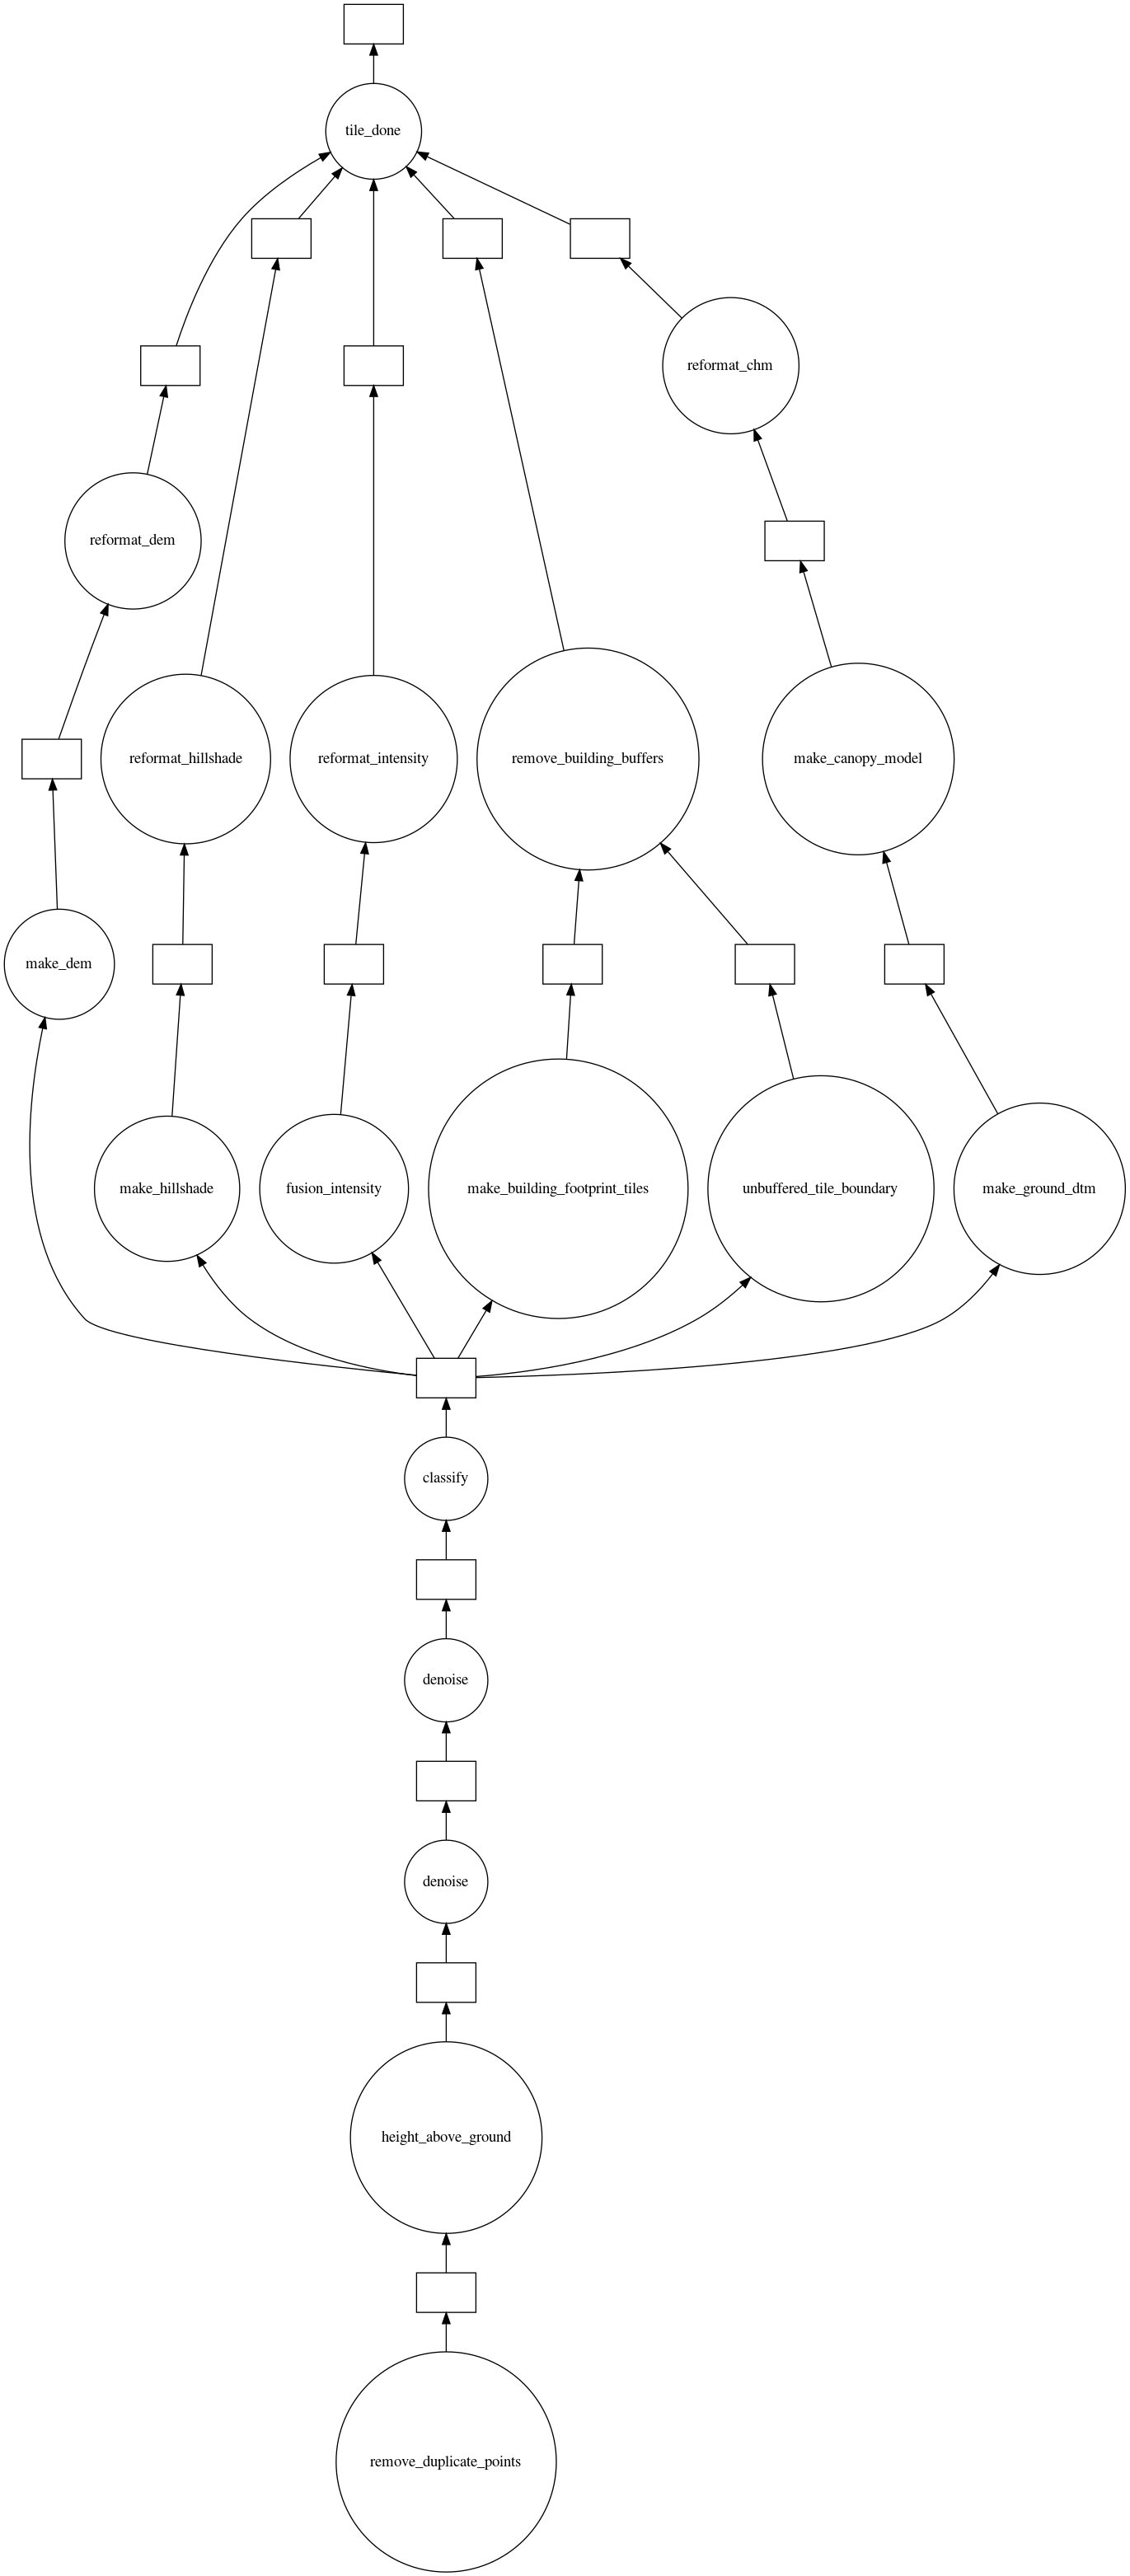

In [33]:
example_tile_graph = c.get(dsk, 'tile_done-{}'.format(tiles_to_process[0]))
example_tile_graph.visualize()

Get Dask to determine how to get to the last state of the tile-processing pipeline, building a computational graph.

In [34]:
tiles_graph = c.get(dsk, 'tiles_done')  # this might take a few minutes

In [35]:
tiles_results = c.persist(tiles_graph)  # start computing
start_time = time.time()

In [36]:
progress(tiles_results)

VBox()

In [ ]:
# tiles_results.result()

In [44]:
processing_summary(tile_ids,
                   finished_tiles,
                   tiles_to_process,
                   os.path.join(INTERIM, 'finished'),
                   os.path.join(INTERIM, 'failed'),
                   start_time)


    Processing Summary
    -------------------
    4,270 tiles in acquisition
        0 tiles previously finished in acquisition

    4,270 tiles being processed in this run
    1,527 tiles from this run finished

        0 tiles failed
    
|=========================                                            |  35.8% this run
|=========================                                            |  35.8% total

elapsed: 	    18h 41m 15s
remaining: 	 1d  9h 34m  8s


In [ ]:
inspect_failures(os.path.join(INTERIM, 'failed'))

In [ ]:
# c.cancel(tiles_results)

In [ ]:
# c.close()
# cluster.close()